In [34]:
from __future__ import division

import warnings
warnings.filterwarnings('always', append=True)
import pprint
import time

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [2]:
import helpy
import helplt
import melting as melt

modules = [helpy, helplt, melt]

In [3]:
rcs = helplt.rcParam_diff('PREPYLAB')

                  KEY:     DEFAULT      =>     PREPYLAB    
           figure.dpi:      100.0       =>       72.0      
     figure.edgecolor:        w         =>   (1, 1, 1, 0)  
     figure.facecolor:        w         =>   (1, 1, 1, 0)  
       figure.figsize:    [6.4, 4.8]    =>    [6.0, 4.0]   
figure.subplot.bottom:       0.11       =>      0.125      
          text.usetex:        0         =>       ...       


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
rcs = helplt.rcParam_diff('POSTPYLAB', rcs)

                  KEY:     DEFAULT      =>     PREPYLAB     =>    POSTPYLAB    
           figure.dpi:      100.0       =>       72.0       =>       ...       
     figure.edgecolor:        w         =>   (1, 1, 1, 0)   =>       ...       
     figure.facecolor:        w         =>   (1, 1, 1, 0)   =>       ...       
       figure.figsize:    [6.4, 4.8]    =>    [6.0, 4.0]    =>       ...       
figure.subplot.bottom:       0.11       =>      0.125       =>       ...       
          interactive:        0         =>       ...        =>        1        
          text.usetex:        0         =>       ...        =>       ...       


In [6]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [41]:
reloaded = [str(m) for m in map(reload, modules) if m.__file__.endswith('.py')]
if reloaded:
    print '\n\t'.join(['reloaded:'] + reloaded)
    print

mess, commit = helpy.getcommit(True)
print mess, str(commit.authored_datetime)[:-9], commit.summary
assert commit.repo.active_branch.name in ('melt')

reloaded:
	<module 'melting' from 'melting.py'>

07f5790(melt+) 2017-08-07 14:49 WIP average merged melting sets


In [42]:
prefix_fmt = '{particle}/{W}x_{config}/{W}x_{config}_{run}'

In [43]:
def load_melting_stuff(particle, W, config, run, **kwargs):
    prefix_fmt = '/Users/leewalsh/Squares/melting/analysis/{particle}/{W}x_{config}/{W}x_{config}_{run}'
    prefix = prefix_fmt.format(particle=particle, W=W, config=config, run=run)
    print prefix

    meta = helpy.load_meta(prefix)

    data = helpy.load_data(prefix)
    tsets = helpy.load_tracksets(
        data, run_repair='interp', run_track_orient=True)
    # to get the benefits of tracksets (interpolation, stub filtering):
    data = np.concatenate(tsets.values())
    data.sort(order=['f', 't'])

    mdata = np.load(prefix + '_MELT.npz')['data']

    frames, mframes = helpy.load_framesets((data, mdata), ret_dict=False)
    end_index = np.searchsorted(mdata['f'], meta['end_frame'])
    shells = melt.split_shells(mdata[:end_index], zero_to=1, do_mean=kwargs.get('do_mean', True), maxshell=W//2)
    shell_means = melt.average_shells(shells, stats, 'f')
    plot_args = melt.make_plot_args(meta)

    return prefix, meta, data, mdata, frames, mframes, shells, shell_means, plot_args

# Shells vs. Time

/Users/leewalsh/Squares/melting/analysis/diag/12x_in/12x_in_1
/Users/leewalsh/Squares/melting/analysis/diag/12x_in/12x_in_2
/Users/leewalsh/Squares/melting/analysis/diag/12x_in/12x_in_3
/Users/leewalsh/Squares/melting/analysis/diag/12x_in/12x_in_4
/Users/leewalsh/Squares/melting/analysis/diag/12x_in/12x_in_MRG
51.0 (51.0 total) seconds
/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_1
/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_2
/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_3
/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_4
/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_5
/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_MRG
55.1 (106.2 total) seconds
/Users/leewalsh/Squares/melting/analysis/pdms/11x_rand/11x_rand_1
/Users/leewalsh/Squares/melting/analysis/pdms/11x_rand/11x_rand_2
/Users/leewalsh/Squares/melting/analysis/pdms/11x_rand/11x_rand_MRG
11.7 (117.9 total) seconds


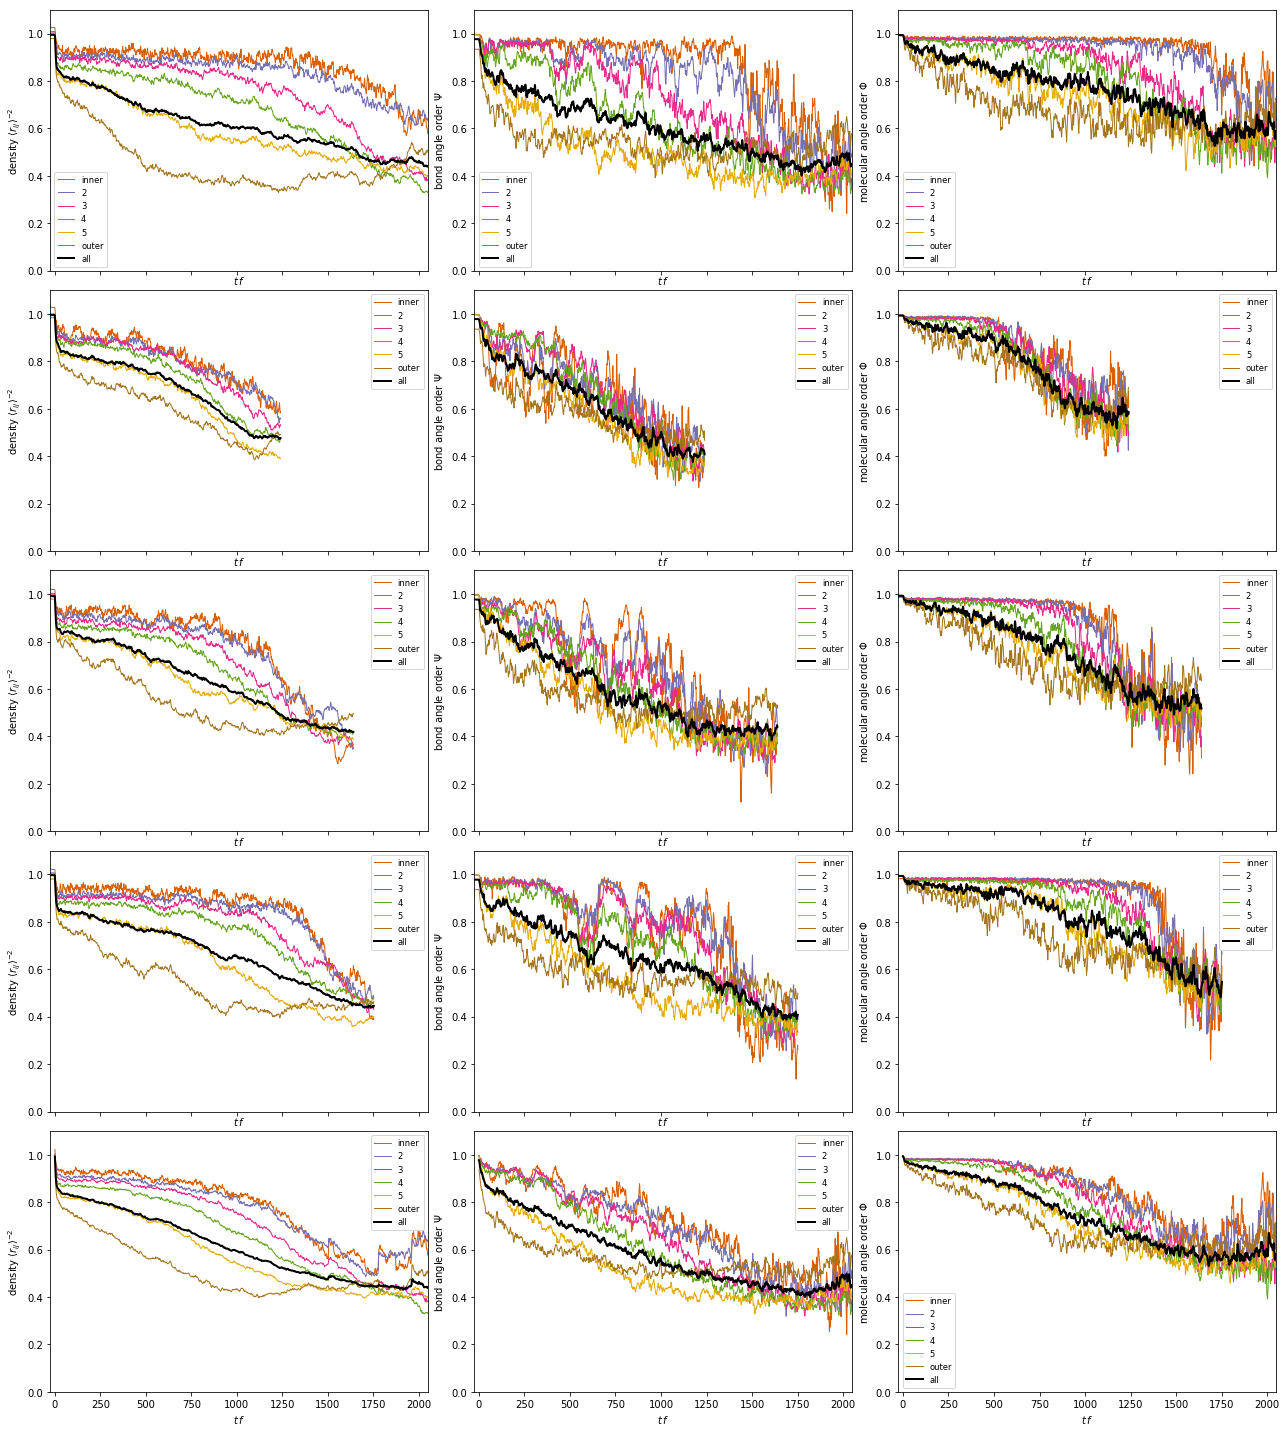

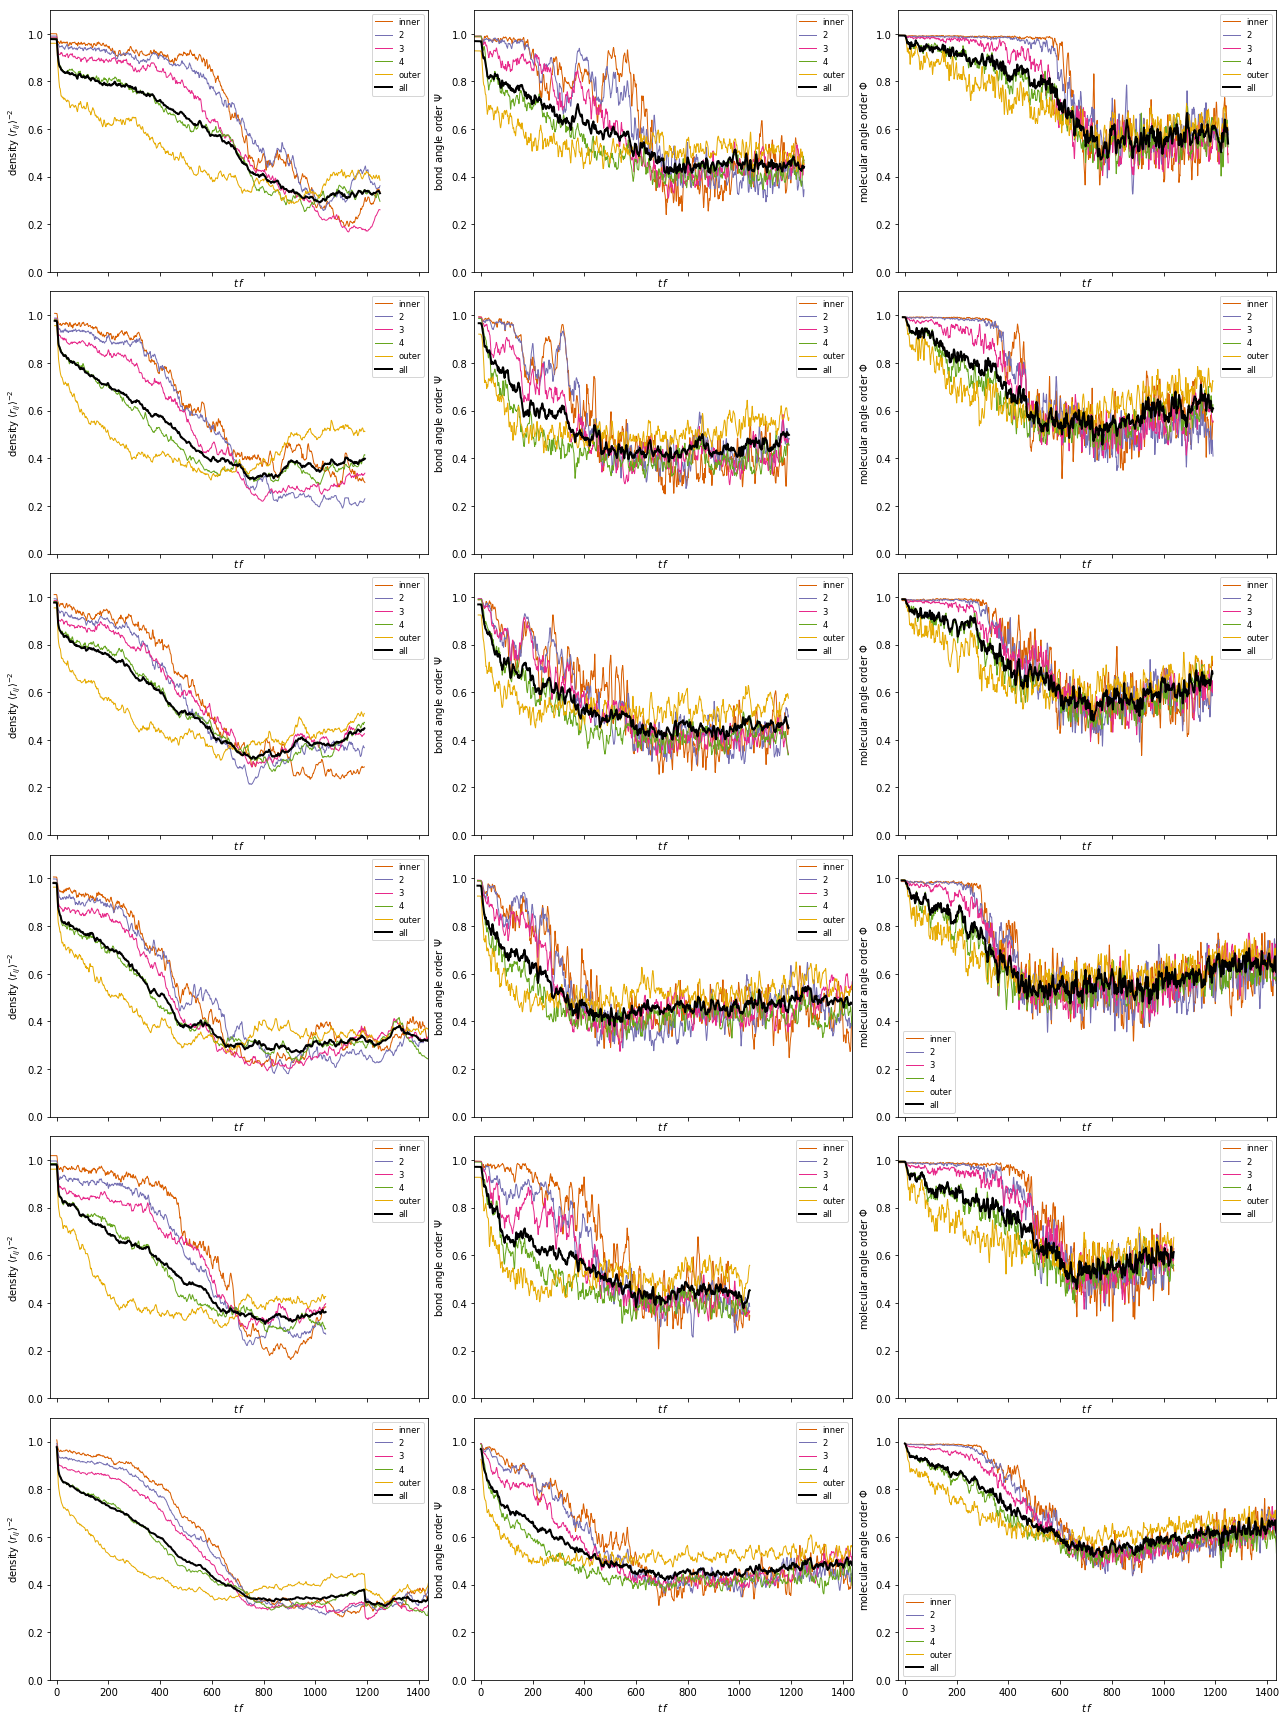

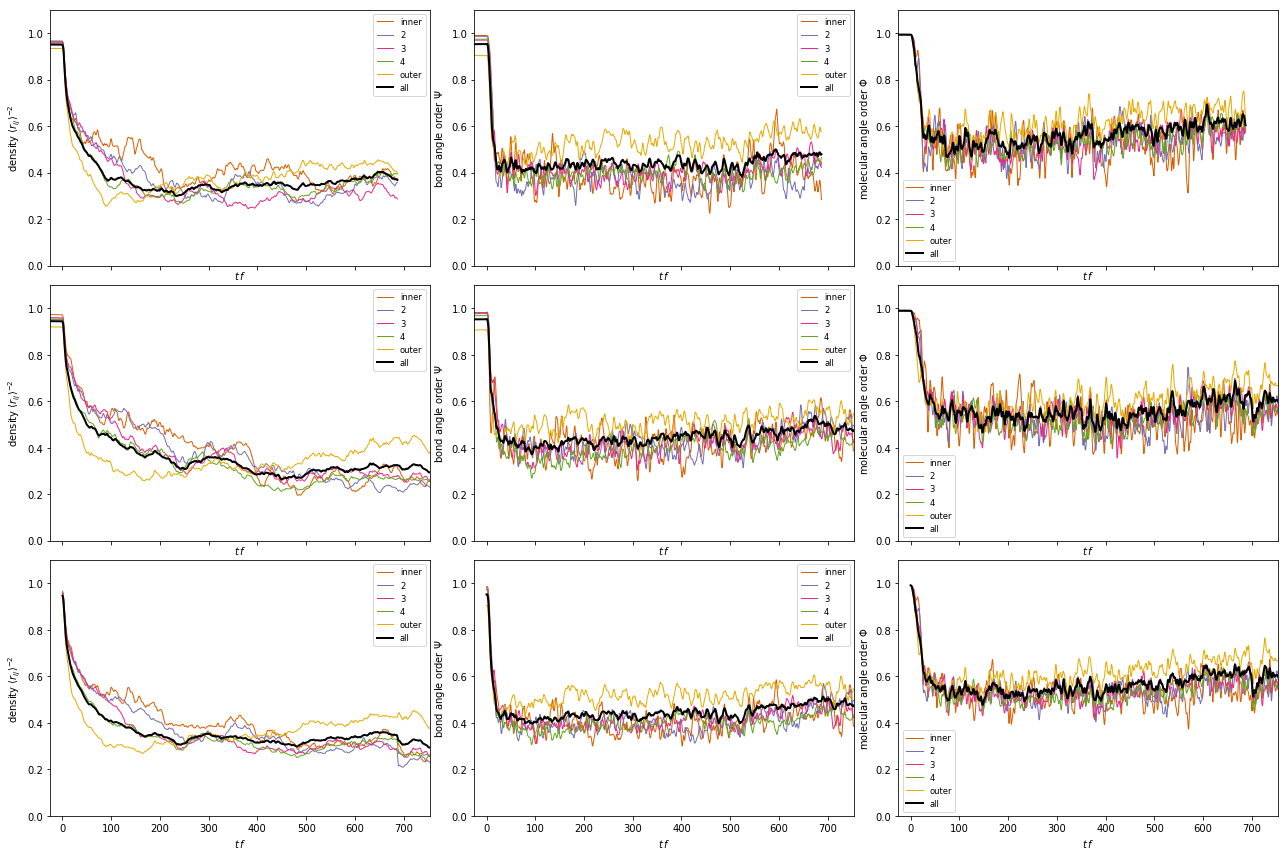

In [44]:
save = False
stats = ['rad', 'dens', 'psi', 'phi'][1:]

datasets = helpy.transpose_dict_of_lists({
    'particle': ['diag', 'pdms', 'pdms'],
    'W':        [12, 11, 11],
    'config':   ['in']*2 + ['rand'],
    'runs':     [range(1, 5) + ['MRG'], range(1, 6) + ['MRG'], range(1, 3) + ['MRG']],
})

time_init = time_done = time.time()
for dataset in datasets:
    ncols, nrows = len(stats), len(dataset['runs'])
    figsize = np.array(plt.rcParams['figure.figsize'])
    figsize *= [ncols, nrows]
    fig, axeses = plt.subplots(figsize=figsize,
                               ncols=ncols, nrows=nrows,
                               sharex='all', sharey='col')

    for run, axes in zip(dataset['runs'], axeses):
        loaded = load_melting_stuff(run=run, **dataset)
        prefix, meta, data, mdata, frames, mframes, shells, shell_means, plot_args = loaded

        for stat, ax in zip(stats, axes):
            ax = melt.plot_by_shell(
                shell_means, 'f', stat,
                start=meta['start_frame'],
                smooth=meta['fps'],
                ax=ax, **plot_args)

    fig.tight_layout(h_pad=0, w_pad=0)

    if save:
        save_name_pattern = '{prefix}_{stat}.pdf'
        save_name = save_name_pattern.format(prefix=prefix, stat='OPs_by_shell_vs_time')
        fig.savefig(save_name, bbox_inches='tight', pad_inches=0)
    time_done, time_start = time.time(), time_done
    print '{:.1f} ({:.1f} total) seconds'.format(time_done - time_start, time_done - time_init)

In [49]:
datasets = helpy.transpose_dict_of_lists({
    'particle': ['diag', 'pdms', 'pdms'],
    'W':        [12, 11, 11],
    'config':   ['in']*2 + ['rand'],
    'runs':     [range(1, 5) + ['MRG'], range(1, 6) + ['MRG'], range(1, 3) + ['MRG']],
})

dataset = datasets[1]
run = 'MRG'
%lprun -f load_melting_stuff loaded = load_melting_stuff(run=run, **dataset)

/Users/leewalsh/Squares/melting/analysis/pdms/11x_in/11x_in_MRG


# Parametric Histograms

In [ ]:
save = False
stats = ['rad', 'dens', 'psi', 'phi']

datasets = helpy.transpose_dict_of_lists({
    'particle': ['diag', 'pdms', 'pdms'],
    'W':        [12, 11, 11],
    'config':   ['in']*2 + ['rand'],
    'runs':     [range(1, 5) + ['MRG'], range(1, 6) + ['MRG'], range(1, 3) + ['MRG']],
})

time_init = time_done = time.time()
for dataset in datasets:
    ncols, nrows = len(stats), len(dataset['runs'])
    figsize = np.array(plt.rcParams['figure.figsize'])
    figsize *= [ncols, nrows]
    fig, axeses = plt.subplots(figsize=figsize,
                               ncols=ncols, nrows=nrows,
                               sharex='all', sharey='col')

    for run, axes in zip(dataset['runs'], axeses):
        loaded = load_melting_stuff(run=run, **dataset)
        prefix, meta, data, mdata, frames, mframes, shells, shell_means, plot_args = loaded


        nrows = ncols = len(stats) - 1
        figsize = list(plt.rcParams['figure.figsize'])
        figsize[0] = min(figsize[0]*ncols,
                         helplt.rc('figure.maxwidth'))
        figsize[1] = min(figsize[1]*nrows,
                         helplt.rc('figure.maxheight'))
        f0 = args.start
        fs = np.array([0, 250, 500, 750, 1000, 1250])
        fbs = ['start'] + fs.tolist() + ['end']
        periods = np.split(mframes, fs + f0)
        for p, period in enumerate(periods):
            period = np.concatenate(period)
            fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols,
                                     sharex='col', sharey='row')
            fig.suptitle(r'$t \, f = [{}, {})$'.format(fbs[p], fbs[p+1]))
            for j, x in enumerate(stats[:-1]):
                for i, y in enumerate(stats[j+1:]):
                    ax = axes[i+j, j]
                    plot_parametric_hist(period, x, y, ax=ax, **plot_args)
